## Library For Characterizing a Crystal Using a NanoVNA

In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

#########################
# plots
#########################

def plot_thru(f, s, clear=False):
    if clear: clear_output(wait=True)
    ax = plt.axes()
    ax.plot(f / 1e6, db(s[:,1]))
    ax.set(xlabel='MHz')
    ax.set(ylabel='dB(S21)')
    
    ax1 = ax.twinx()
    ax1.grid()
    ax1.plot(f / 1e6, np.angle(s[:,1], deg=True), 'tab:red')
    ax1.set(ylabel='theta')

    plt.show()

def plot_gamma(f, s, clear=False):
    if clear: clear_output(wait=True)
    ax = plt.axes()
    ax.plot(f / 1e6, db(s[:,0]))
    ax.set(xlabel='MHz')
    ax.set(ylabel='dB(S11)')
    plt.show()
    
#########################
# utilities
#########################

# convert a reflection (S11) measurement of a component
# to a equivalent series thru (S21) one with the 
# component in series with the VNA ports 1 and 2.
def toseries(s, RL=50):
    d = s * 0
    s11 = s[:,0]
    z = RL * (1 + s11) / (1 - s11)
    s21 = 2 * RL / (2 * RL + z)
    d[:,1] = s21
    return d

# convert s-parameter to db
def db(x):
    return 20 * np.log10(abs(x))

# attenuation to capacitive equivalent
def thru_stray(f, s, RL=50):
    mag = abs(s[:,1])
    XC = 2 * RL * (1 / mag - 1)
    return 1 / (2 * np.pi * f * XC)

# frequency of thru at minimum magnitude
def thru_fmin(f, s):
    mag = abs(s[:,1])
    return f[np.argmin(mag)]
    
# frequency of thru at maximum magnitude
def thru_fmax(f, s):
    mag = abs(s[:,1])
    return f[np.argmax(mag)]

# frequency and magnitude of thru at zero phase
def thru_zerophase(f, s):
    mag = abs(s[:,1])
    ph = np.angle(s[:,1])
    i = np.where(np.diff(np.sign(ph)) != 0)[0]
    return f[i][0], mag[i][0]

# bandwidth of thru
def thru_bandwidth(f, s, theta=45):
    theta *= np.pi / 180
    ph = np.angle(s[:,1])
    if ph[0] > ph[-1]: 
        f, ph = f[::-1], ph[::-1] 
    f1, f2 = np.interp([-theta, theta], ph, f)
    return abs(f2 - f1) / np.tan(theta)

def crystal_phasemethod(fs, fp, fs_bw, fs_mag, RL, STRAY):
    RM = 2 * RL * (1 / fs_mag - 1)
    REFF = RM + 2 * RL
    CM = fs_bw / (2 * np.pi * REFF * fs**2)
    LM = REFF / (2 * np.pi * fs_bw)
    QU = 2 * np.pi * fs * LM / RM
    CO = CM / (fp / fs - 1) / 2 - STRAY
    print(f'FS {fs:.1f} Hz')
    print(f'FP {fp:.1f} Hz')
    print(f'RM {RM:.3f} ohm')
    print(f'CM {CM * 1e15:.3f} fF')
    print(f'LM {LM * 1e3:.3f} mH')
    print(f'QU {QU:.1f}')
    print(f'CO {CO * 1e12:.3f} pF')
    
###########################################

def sweep_stray(sweep, reflection=False):
    f, s = sweep()
    if reflection:
        s = toseries(s)
    cap = thru_stray(f, s)
    print('maximum = {:.2f} pF'.format(np.max(cap) / 1e-12))
    print('median  = {:.2f} pF'.format(np.median(cap) / 1e-12))
    print('minimum = {:.2f} pF'.format(np.min(cap) / 1e-12))
    ax = plt.axes()
    ax.plot(f / 1e6, cap * 1e12)
    ax.set(xlabel='MHz')
    ax.set(ylabel='pF')
    plt.show()


def characterize_crystal(sweep, STRAY=0, alpha=1.1, clear=True, reflection=False):
    # make a first stab at fs, fp, and bandwidth
    f, s = sweep()
    if reflection:
        s = toseries(s)
    plot_thru(f, s)
    fs = thru_fmax(f, s)
    fp = thru_fmin(f, s)
    df = fp - fs
    fs_bw = df
    fp_bw = df

    # find fs, fs_mag, and fs_bw
    for i in range(3):
        if fs_bw <= 0: return
        start = fs - fs_bw / 2 * alpha
        stop = fs + fs_bw / 2 * alpha
        f, s = sweep(start=start, stop=stop)
        if reflection:
            s = toseries(s)
        fs_bw = thru_bandwidth(f, s)       # measure bandwidth
        fs, fs_mag = thru_zerophase(f, s)  # frequency and mag of zero phase
        plot_thru(f, s, clear=clear)

    # find fp
    start = fp - fp_bw / 2
    stop = fp + fp_bw / 2
    f, s = sweep(start=start, stop=stop)
    if reflection:
        s = toseries(s)
    fp, mag = thru_zerophase(f, s)
    plot_thru(f, s, clear=clear)

    # characterize crystal
    crystal_phasemethod(fs=fs, fp=fp, fs_bw=fs_bw, fs_mag=fs_mag, RL=50, STRAY=STRAY)

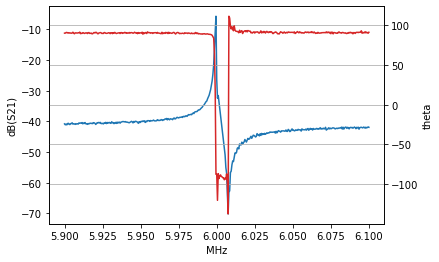

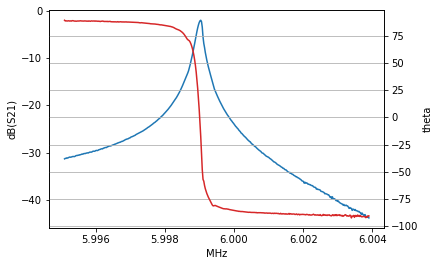

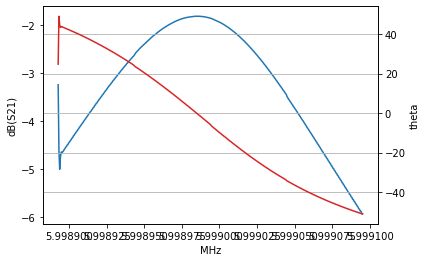

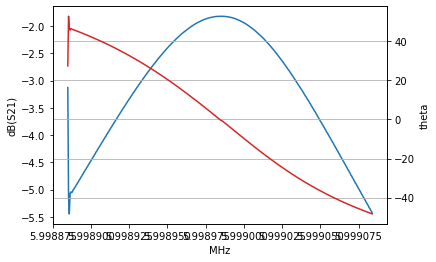

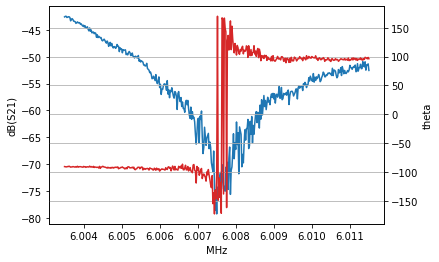

FS 5998983.9 Hz
FP 6007500.0 Hz
RM 23.329 ohm
CM 6.743 fF
LM 104.388 mH
QU 168661.2
CO 2.375 pF


In [2]:
from nanocli import getvna
sweep = getvna()
# Set reflection to True if measuring the crystal using a S11
# reflection measurement rather than a S21 series thru one
# Set clear to True to animate the measurement.
characterize_crystal(sweep, reflection=True, clear=False)